# Federated LLM Fine-tuning

O fine-tuning federado de modelos LLM com Flower e PEFT permite ajustar modelos pré-treinados a dados específicos de cada usuário sem comprometer sua privacidade, já que os dados não são compartilhados entre os clientes. Utiliza-se o PEFT (Parameter-Efficient Fine-Tuning) para otimizar o processo de ajuste fino, reduzindo o uso de recursos por meio de técnicas como quantização em 4-bit e 8-bit, diminuindo assim o consumo de VRAM.


```shell
git clone --depth=1 https://github.com/DinhoVCO/MO809A.git _tmp \
    && mv _tmp/FederatedLLM/FT_lite ./ \
    && rm -rf _tmp \
    && cd FT_lite
```

- [Federated LLM FT ](https://flower.ai/blog/2024-03-14-llm-flowertune-federated-llm-finetuning-with-flower/)
- [TUTORIAL ](https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/1/introduction)


## 1. Import packages and utilities

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import load_dataset
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)
from utils.utils import * 

function 'cadam32bit_grad_fp32' not found


* Load configuration.

In [2]:
cfg = get_config("federated_lite")

## 2. Dataset partition

In [3]:
partitioner = IidPartitioner(num_partitions=cfg.flower.num_clients)
fds = FederatedDataset(
    dataset=cfg.dataset.name,
    partitioners={"train": partitioner}
)

partition_zero = fds.load_partition(0) 
partition_zero

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 1698
})

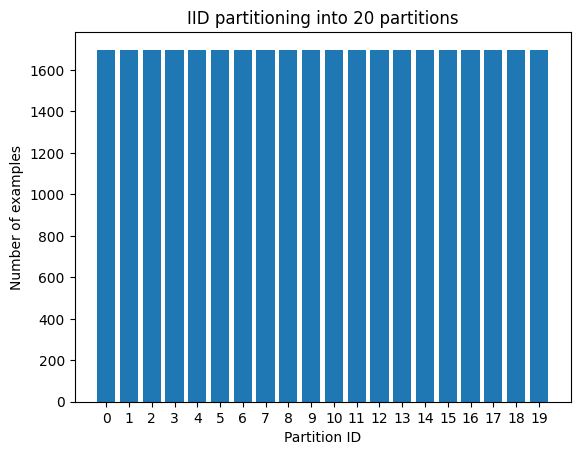

In [4]:
visualize_partitions(fds)

## 3. Client and Server

* Load the tokenizer and other components.

In [5]:
(
tokenizer,
data_collator,
formatting_prompts_func,
) = get_tokenizer_and_data_collator_and_propt_formatting(
    cfg.model.name, 
    cfg.model.use_fast_tokenizer,
    cfg.train.padding_side,
)

* Define the client.

In [6]:
def gen_client_fn(
    fds,
    tokenizer,
    formatting_prompts_func,
    data_collator,
    model_cfg: DictConfig,
    train_cfg: DictConfig,
    save_path: str,
) -> Callable[[str], FlowerClient]:  # pylint: disable=too-many-arguments
    """Generate the client function that creates the Flower Clients."""

    def client_fn(context: Context) -> FlowerClient:
        """Create a Flower client representing a single organization."""

        # Let's get the partition corresponding to the i-th client
        partition_id = int(context.node_config["partition-id"])
        client_trainset = fds.load_partition(partition_id, "train")
        client_trainset = client_trainset.remove_columns(["instruction"])
        client_trainset = client_trainset.rename_column("input", "instruction")
        client_trainset = client_trainset.rename_column("output", "response")
        return FlowerClient(
            model_cfg,
            train_cfg,
            client_trainset,
            tokenizer,
            formatting_prompts_func,
            data_collator,
            save_path,
        ).to_client()

    return client_fn

#### Dados privados
Embora o aprendizado federado não compartilhe os dados brutos entre os clientes, apenas intercambie os pesos do modelo, persiste o problema de vazamento de informações em modelos de linguagem grandes (LLMs). Os LLMs tendem a memorizar informações específicas em seus parâmetros durante o processo de treinamento, especialmente quando trabalham com dados sensíveis ou privados. Isso significa que, embora os dados originais não sejam compartilhados explicitamente, os parâmetros ajustados do modelo podem incorporar detalhes que refletem aspectos dos dados privados, representando um potencial risco de privacidade

In [7]:
save_path = "./my_fl_model_dp"
client = fl.client.ClientApp(
    client_fn=gen_client_fn(
        fds,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        cfg.model, 
        cfg.train, 
        save_path,
    ),
    mods=[fixedclipping_mod] 
)

### Privacidade Diferencial
A privacidade diferencial é uma técnica que oferece garantias estatísticas para proteger a informação individual em um conjunto de dados, adicionando ruído aos resultados das análises ou algoritmos. Isso permite fazer inferências úteis em nível de grupo, enquanto oculta as contribuições de dados individuais, garantindo que o resultado não mude significativamente se um único dado for adicionado ou removido. Aplica-se principalmente para proteger dados sensíveis, como os de saúde ou financeiros, evitando que informações pessoais sejam inferidas, mesmo quando combinadas com dados externos ou ataques avançados de reidentificação.

- [Privacidade Diferencial](https://flower.ai/docs/framework/explanation-differential-privacy.html)

#### Recorte do lado do cliente
O recorte do lado do cliente é uma técnica no aprendizado federado onde cada cliente aplica localmente um limite na magnitude de seus gradientes antes de enviá-los ao servidor central para agregação. Se os gradientes calculados excedem um limite especificado, eles são escalados para que sua magnitude não ultrapasse esse valor, preservando assim sua direção original. Essa abordagem reduz o risco de vazamento de dados sensíveis e distribui a carga computacional, evitando que o servidor precise recortar as atualizações de todos os clientes. No entanto, exige que o servidor comunique o limite de recorte aos clientes e confie que eles o apliquem corretamente, o que pode introduzir desafios de coordenação e consistência no processo de treinamento.
- [Use Differential Privacy](https://flower.ai/docs/framework/how-to-use-differential-privacy.html)
![Logo de Python](https://flower.ai/docs/framework/_images/clientsideCDP.png)


Posteriormente, utiliza-se o mecanismo gaussiano para adicionar ruído com o objetivo de distorcer a soma das atualizações de todos os clientes. A quantidade de ruído é escalada de acordo com o valor da sensibilidade para obter uma garantia de privacidade.

* Define the server function and add Differential Privacy.

In [23]:
def server_fn(context: Context):
    # Define the Strategy
    strategy = fl.server.strategy.FedAvg(
        min_available_clients=cfg.flower.num_clients, # total clients
        fraction_fit=cfg.flower.fraction_fit, # ratio of clients to sample
        fraction_evaluate=0.0, # No federated evaluation
        # A (optional) function used to configure a "fit()" round
        on_fit_config_fn=get_on_fit_config(),
        # A (optional) function to aggregate metrics sent by clients
        fit_metrics_aggregation_fn=fit_weighted_average,
        # A (optional) function to execute on the server after each round. 
        # In this example the function only saves the global model.
        evaluate_fn=get_evaluate_fn( 
            cfg.model,
            cfg.train.save_every_round,
            cfg.flower.num_rounds,
            save_path,
        ),
    )

    # Add Differential Privacy
    sampled_clients = cfg.flower.num_clients*strategy.fraction_fit
    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy, 
        noise_multiplier=cfg.flower.dp.noise_mult,
        clipping_norm=cfg.flower.dp.clip_norm, 
        num_sampled_clients=sampled_clients
    )
    
    # Number of rounds to run the simulation
    num_rounds = cfg.flower.num_rounds
    config = fl.server.ServerConfig(num_rounds=num_rounds)
    
    return fl.server.ServerAppComponents(strategy=strategy, config=config) 

* Instantiate the ServerApp.

In [24]:
server = fl.server.ServerApp(server_fn=server_fn)

## 4. Run

* Run the simulation.

In [25]:
fl.simulation.run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.flower.num_clients,
    backend_config={"init_args": backend_setup}
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0, {}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0025 stdev added
INFO :      fit progress: (1, 0.0, {}, 360.854782099952)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 20)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0025 stdev added
INFO :      fit progress: (2, 0.0, {}, 709.8555060999934)
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out

## 5. Run the fine-tuned model. 

In [8]:
# Load dataset
train_dataset = load_dataset(cfg.dataset.name, split='train')
# Select training example
example_index = 6
data_point = train_dataset[example_index]

In [9]:
prompt = data_point["input"]
prompt

'What are the possible causes of low glucose and high C-peptide levels?'

In [10]:
answer = data_point["output"]
answer

'Low glucose and high C-peptide levels can be caused by an insulinoma or the use of sulfonylurea drugs.'

* Modelo pre-treinado

In [11]:
model, tokenizer = load_pretrained_model(cfg.model.name)

Carregando o tokenizador para EleutherAI/pythia-70m...
Carregando o modelo pré-treinado EleutherAI/pythia-70m...
O modelo foi carregado com sucesso no dispositivo: cpu


In [12]:
answer1 = generate_text(model, tokenizer, data_point["input"], max_length=100)
print(answer1)

What are the possible causes of low glucose and high C-peptide levels?
: The main reason is that there may be a decrease in insulin secretion, which can lead to an increase or even death. In fact it has been suggested by other studies (eurotide et al., [@B31]; Kahnke & Hickman; @Kahler1) for example using serum albumin as well \[[@R32]\]. However this study did not find any significant differences between these two conditions


* Modelo Fine Tuning Federado

In [13]:
#save_path = "./my_fl_model"
lora_adapter_path = f"{save_path}/peft_10/"

# Cargar el modelo combinado con el adaptador LoRA y el tokenizador
model_FL, tokenizer_FL = load_model_with_lora_adapter(cfg.model.name, lora_adapter_path)

Carregando o tokenizador para EleutherAI/pythia-70m...
Carregando o modelo pré-treinado EleutherAI/pythia-70m...
Aplicando o adaptador LoRA de ./my_fl_model_dp/peft_10/...
trainable params: 0 || all params: 70,623,232 || trainable%: 0.0
O modelo combinado com o adaptador LoRA foi carregado com sucesso.


In [14]:
answer2 = generate_text(model_FL, tokenizer_FL, data_point["input"], max_length=100)
print(answer2)

What are the possible causes of low glucose and high C-peptide levels?
Certain questions that can be addressed include: (1) how to use a specific chemical as well for diagnosis, treatment objectives/conditions;(2);and why not. The nature or extent may vary with disease stage in which patients will have at least one clinical reason by including these symptoms during follow up studies on this subject's illness when they were diagnosed because their condition is known if you report any other symptom before your
